<a href="https://colab.research.google.com/github/anmolsriv/COMP/blob/main/DWF21_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Warehouses Design and Use


## Goals
The goal of this assignment is to gain experience and practice constructing, populating, and querying  a data warehouse. We will continue to use our ice cream food truck for this exercise. 

You will be further developing your skills in writing declarative SQL. In addition, you will see the impact of grain size on query time and table size.

## Your task
Your task is to write SQL code, and fill in some values to a few Python cells, as directed in the assignment. Your notebook must run without error. Be sure to test that you can run all of the cells (except the # LOCALDB cell) from a fresh start, without error.

## Grading
This assignment is worth 50 points.  The number of points assigned to each component is indicated.

## Autograding
We will use an autograder for first pass grading of this assignment. In order for our autograder to work, we need to connect your solution to a local database. 

**DO NOT RUN CELLS THAT START WITH THE COMMENT `# LOCALDB` and do not remove those cells.**

For cells that contain your answer, replace the `SELECT 1` SQL code with your solution. Do not change the first line of the cell or remove the following cell.

We are using an autograder for the first pass grading. For the autograder to work, you need to complete your work in the appropriate cells and name and order the attributes in your results as directed. 

**It's critical that you use the attribute names and sort order as directed. If attribute name(s) are not specfied, use the name in the source table.**

## Academic Honesty
The following level of collaboration is allowed on this assignment: 

You may discuss the assignment with other class members at a high level. What is not allowed is direct examination of anyone else's SQL code (on a computer, email, whiteboard, etc.) or allowing anyone else to see your SQL  code. You may also use (and in fact are encouraged to use) the PostgreSQL reference manual 

https://www.postgresql.org/docs/10/index.html

You may use the search engine of your choice to look up the syntax for PostgreSQL commands, but may not use it to find answers. Remember to cite your sources!


## Useful Information
The following PostgreSQL functions may be helpful.

EXTRACT EXTRACT(<unit> FROM <attribute>). Can be used to extract hour, month, year, day of week, etc. from dates

:: Casts the attribute to the left of the :: to the type specified on the right
    
## What to submit

Submit this jupyter notebook containing your table definitions, queries, code, and results. Be sure to provide code to delete any VIEWs and TABLEs other that the start 4 tables.



## Background
The system we have designed for our ice cream food truck is great for recording orders and sales. However, due to its focus on recipes and tickets, queries to determine strategy (e.g. most popular ingredients, etc.) can be complex. Here, you will construct and populate a Star Schema for ingredient.



## Data 

This section describes the tables that provide data for this assignment.


We leverage the following base tables in this assignment:

* truckEvent: Details of the events where the food truck sold ice cream.  Attributes include:

    * EventId: Primary key. Unique id of each event
    * EventName: Text name for the event
    * EventStart: Start time of the event
    * EventPlannedEnd: Time the event was expected to end
    * EventActualEnd: Time the event actually ended
    * EventStatus: Status indicating if the event is planned, in progress,  completed, or cancelled
    * TotalDollarSales: Sum of the selling price of all of the products sold during the event
    * TotalNumProducts: Number of products sold during the event 
    * TotalNumTickets: Number of tickets created during the event 

* ticket: Details of each set of products purchased together during an event

    * TicketId: Unique id of each ticket
    * EventId: Id of event where the ticket was created
    * TicketTime: Time when the ticket was created
    * NumProducts; Number of products purchased together on this ticket
    * TotalPrice: Sum of selling price of all products purchased together on this ticket

* productSold:  Details about each product sold during an event

    * productSoldId: Unique id of each product sold
    * ProductCode: Code identifying the product that was sold
    * TicketId: Id of the ticket in which this product was sold
    * Price: Selling price of the product

* saleDetail: Detail about the ingredient(s) used in each product sold
    * SaleDetailId: Unique id of each detail
    * ProductSoldId: The id of the productSold which this saleDetail is part of
    * IngName: Name of the ingredient
    * Qty: Quantity of the ingredient
    * Unit: Unit of measure of the ingredient
    * Detail: Detail / choice made for the ingredient (e.g. **vanilla** or **tall**)



In [ ]:
# LOCALDB
# connect to grader database
import psycopg2
from configparser import ConfigParser

def config(filename='.pg_service.conf', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

params = config()
# build the connection string
def make_conn_str(params):

    return f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}:{params['port']}/{params['dbname']}"
        
# connect to the database
conn_str = make_conn_str(params)
%load_ext sql
%sql $conn_str 
%config SqlMagic.displaylimit=100


## Initialization

The next cell needs to be run each time you start up Google Colab.

In [2]:
# colab install
!pip install --upgrade pip
!pip install SQLAlchemy==1.3.23
!pip install psycopg2-binary
!apt install postgresql postgresql-contrib &>log
!service postgresql start
!sudo -u postgres psql -c "CREATE USER root WITH SUPERUSER"
# set connection
%load_ext sql
%config SqlMagic.autolimit=100
# Limit queries to 100 results. Increase this value if needed, but recognize that your notebook will increase in size as well. %config SqlMagic.displaylimit=100
%sql postgresql+psycopg2://@/postgres
!sudo -u postgres createdb ricedb

     |████████████████████████████████| 1.7 MB 12.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 1.3 MB 15.4 MB/s            
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 1.4.25
    Uninstalling SQLAlchemy-1.4.25:
      Successfully uninstalled SQLAlchemy-1.4.25
     |████████████████████████████████| 3.4 MB 13.0 MB/s            
 * Starting PostgreSQL 10 database server
   ...done.
CREATE ROLE



The following data files are provided for this assignment:

* productsold.csv
* saledetail.csv
* ticket.csv
* truckevent.csv

Create these tables:

In [3]:
%%sql
DROP TABLE IF EXISTS productsold CASCADE;
CREATE TABLE IF NOT EXISTS productsold
(
    productsoldid integer NOT NULL ,
    productcode CHAR(3) NOT NULL,
    ticketid integer NOT NULL,
    price numeric(10,2) NOT NULL,
    PRIMARY KEY (productsoldid)
);

DROP TABLE IF EXISTS salerecord CASCADE;
CREATE TABLE IF NOT EXISTS salerecord
(
    salerecordid integer NOT NULL,
    productsoldid integer,
    ingname character varying(50)  NOT NULL,
    qty numeric(10,2) NOT NULL,
    unit character varying(20)  NOT NULL,
    detail character varying(50),
    PRIMARY KEY (salerecordid)
);

DROP TABLE IF EXISTS ticket CASCADE;
CREATE TABLE IF NOT EXISTS ticket
(
    ticketid integer NOT NULL,
    eventid integer NOT NULL,
    tickettime timestamp without time zone NOT NULL,
    numproducts integer NOT NULL DEFAULT 0,
    totalprice numeric(5,2) NOT NULL DEFAULT 0,
    PRIMARY KEY (ticketid)
);

DROP TABLE IF EXISTS truckevent CASCADE;
CREATE TABLE IF NOT EXISTS truckevent
(
    eventid integer NOT NULL,
    eventname character varying(100)  NOT NULL,
    eventstart timestamp without time zone,
    eventplannedend timestamp without time zone,
    eventactualend timestamp without time zone,
    eventstatus character varying(30)  NOT NULL,
    menuname character varying(30),
    totaldollarsales numeric(10,2),
    totalnumproducts integer,
    totalnumtickets integer,
    PRIMARY KEY (eventid)
);

 * postgresql+psycopg2://@/postgres
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

## Load the data

In [5]:
%%sql
COPY productsold(productsoldid,productcode,ticketid,price) FROM '/content/productsold.csv' CSV HEADER;
COPY ticket FROM  '/content/ticket.csv'  CSV  HEADER; 
COPY salerecord FROM  '/content/salerecord.csv'  CSV HEADER; 
COPY truckevent FROM  '/content/truckevent.csv'  CSV HEADER; 

 * postgresql+psycopg2://@/postgres
14322 rows affected.
3398 rows affected.
73096 rows affected.
62 rows affected.


[]

In [6]:
%%sql
-- there should be 14322 records 
SELECT COUNT(1) 
FROM productsold;

 * postgresql+psycopg2://@/postgres
1 rows affected.


count
14322


In [7]:
%%sql
-- there should be 3398
SELECT COUNT(1) 
FROM ticket;

 * postgresql+psycopg2://@/postgres
1 rows affected.


count
3398


In [8]:
%%sql 
-- 73096
SELECT COUNT(1) 
FROM salerecord;

 * postgresql+psycopg2://@/postgres
1 rows affected.


count
73096


In [9]:
%%sql 
-- 62
SELECT COUNT(1) 
FROM truckevent;

 * postgresql+psycopg2://@/postgres
1 rows affected.


count
62


## Data Warehouse Structure

In order to write the queries specified below, you will need to construct a star schema for **ingredient used** (salerecord).

While many star schema are possible, we constain our data warehouse to a fixed set of fact and dimension tables, as follows.

Define the following fact and dimension tables. **Use the exact table names provided**. What you call your attributes within each table is up to you. What data you need in each table should be sufficient to answer all of the questions asked.

Assign surrogate primary keys and appropriate foreign keys for each table.  When creating your tables, keep in mind that data warehouses trade-off storage space for computation. That is, it is better to precompute facts you might need and store the result in a fact table versus computing them on the fly. Be sure to use good data warehouse design: Don't snowflake your dimensions, denormalize where appropriate, etc. 

1. Create (1 point each) and populate from the source data (1 point each) the following tables. 

    1. DateDim: This dimension table should contain a unique, system assigned numeric identifier, as well as attributes that separate out the day, day of the week, month, and year.

    1. EventDim: This dimension table is a dimension table based on the truckevent table.  Assign a unique, system identifier as the primary key.

    1. TicketDim: This dimension table  a dimension table based on the ticket table.  Assign a unique, system identifier as the primary key.

    1. ProductSoldDim:  A dimension table based on the productsold table. Assign a unique, system identifier as the primary key.


1. Create (5 points) and populate from the source data (5 points) the following table.

    1. IngUsedFact:  A fact table based on the saleRecord table. The attributes should include foreign key references to the aforementioned dimension tables as well as any additional attributes needed to construct the additional fact tables specified and answer the queries specified below.  You should also include a degenerate dimension that should be populated with the saleRecord id that this IngUsedFact record is based on.


1. Create (1 point each) and populate from the source data (1 point each) the following tables. 

    1. IngUsedByDayFact: This fact table should aggregate the contents of IngUsedFact by the date the ingredient was used. The table should have appropriate primary and foreign keys.

    1. IngUsedByMonthFact: This table should aggregate the IngUsedFact table by month \& year and should have appropriate primary and foreign keys.


Keep in mind that when you populate your the `IngUsedFact` table, you need to reference the appropriate records in the dimension tables.

In [36]:
%%sql
SELECT 1;

-- Create the dimension and fact tables

DROP TABLE IF EXISTS DateDim CASCADE;
CREATE TABLE IF NOT EXISTS DateDim 
  (id SERIAL PRIMARY KEY,
  day integer,
  dayofweek integer,
  month integer,
  year integer
  );

DROP TABLE IF EXISTS EventDim CASCADE;
CREATE TABLE IF NOT EXISTS EventDim 
  (id SERIAL PRIMARY KEY,
    eventname character varying(100)  NOT NULL,
    eventstart timestamp without time zone,
    eventplannedend timestamp without time zone,
    eventactualend timestamp without time zone,
    eventstatus character varying(30)  NOT NULL,
    menuname character varying(30),
    totaldollarsales numeric(10,2),
    totalnumproducts integer,
    totalnumtickets integer,
    eventid integer
  );

DROP TABLE IF EXISTS TicketDim CASCADE;
CREATE TABLE IF NOT EXISTS TicketDim 
  (id SERIAL PRIMARY KEY,
    tickettime timestamp without time zone NOT NULL,
    numproducts integer NOT NULL DEFAULT 0,
    totalprice numeric(5,2) NOT NULL DEFAULT 0,
    ticketid integer
  );

DROP TABLE IF EXISTS ProductSoldDim CASCADE;
CREATE TABLE IF NOT EXISTS ProductSoldDim 
  (id SERIAL PRIMARY KEY,
    productcode CHAR(3) NOT NULL,
    price numeric(10,2) NOT NULL,
    productsoldid integer
  );

DROP TABLE IF EXISTS IngUsedFact CASCADE;
CREATE TABLE IF NOT EXISTS IngUsedFact 
  (id SERIAL PRIMARY KEY,
    ingname character varying(50)  NOT NULL,
    qty numeric(10,2) NOT NULL,
    unit character varying(20)  NOT NULL,
    detail character varying(50),
    productsold integer,
    date integer,
    event integer,
    ticket integer,
    salerecordid integer NOT NULL,
    CONSTRAINT ingUsedprodsoldfk FOREIGN KEY(productsold) references ProductSoldDim(id),
    CONSTRAINT ingUseddatefk FOREIGN KEY(date) references DateDim(id),
    CONSTRAINT ingUsedeventfk FOREIGN KEY(event) references EventDim(id),
    CONSTRAINT ingUsedticketfk FOREIGN KEY(ticket) references TicketDim(id),
    CONSTRAINT ingUsedsalerecordDDfk FOREIGN KEY(salerecordid) references saleRecord(salerecordid)
  );

DROP TABLE IF EXISTS IngUsedByDayFact CASCADE;
CREATE TABLE IF NOT EXISTS IngUsedByDayFact 
  (id SERIAL PRIMARY KEY,
    date integer,
    month integer,
    year integer,
    ingname character varying(50),
    qty numeric(10,2) NOT NULL,
    unit character varying(20)  NOT NULL,
    detail character varying(50)
  );

DROP TABLE IF EXISTS IngUsedByMonthFact CASCADE;
CREATE TABLE IF NOT EXISTS IngUsedByMonthFact 
  (id SERIAL PRIMARY KEY,
    month integer,
    year integer,
    ingname character varying(50),
    qty numeric(10,2) NOT NULL,
    unit character varying(20)  NOT NULL,
    detail character varying(50)
  );  



 * postgresql+psycopg2://@/postgres
1 rows affected.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

In [37]:
%%sql
-- populate dimension tables
SELECT 1;

INSERT INTO DateDim 
(day, dayofweek, month, year) 

(
  SELECT temp.day, temp.dow, temp.month, temp.year
    FROM 
    (
      SELECT EXTRACT(DAY FROM tickettime) as day, EXTRACT(DOW FROM tickettime) as dow,
      EXTRACT(MONTH FROM tickettime) as month, EXTRACT(YEAR FROM tickettime) as year
      FROM ticket 
      GROUP BY tickettime
    ) temp
    GROUP BY temp.day, temp.dow, temp.month, temp.year
);


INSERT INTO EventDim 
(eventname, eventstart, eventplannedend, eventactualend, eventstatus, menuname, totaldollarsales, totalnumproducts, totalnumtickets, eventid)

(
  SELECT eventname, eventstart, eventplannedend, eventactualend, eventstatus, menuname, totaldollarsales, totalnumproducts, totalnumtickets, eventid
  FROM truckevent
);

INSERT INTO TicketDim 
(tickettime, numproducts, totalprice, ticketid)

(
  SELECT tickettime, numproducts, totalprice, ticketid
  FROM ticket
);

INSERT INTO ProductSoldDim 
(productcode, price, productsoldid)

(
  SELECT productcode, price, productsoldid
  FROM productsold
);

 * postgresql+psycopg2://@/postgres
1 rows affected.
67 rows affected.
62 rows affected.
3398 rows affected.
14322 rows affected.


[]

In [38]:
%%sql
-- populate fact tables
SELECT 1;

INSERT INTO IngUsedFact  
(ingname, qty, unit, detail, productsold, date, event, ticket, salerecordid)

(
  SELECT sr.ingname, sr.qty, sr.unit, sr.detail, psd.id, dd.id, ed.id, td.id, sr.salerecordid 
  FROM saleRecord sr 
    JOIN productsold ps
      ON sr.productsoldid = ps.productsoldid 
    JOIN ticket t 
      ON t.ticketid = ps.ticketid 
    JOIN truckevent te 
      ON te.eventid = t.eventid
    JOIN DateDim dd
      ON dd.day = EXTRACT(DAY FROM t.tickettime) AND dd.dayofweek = EXTRACT(DOW FROM t.tickettime) AND 
      dd. month = EXTRACT(MONTH FROM t.tickettime) AND dd.year = EXTRACT(YEAR FROM t.tickettime) 
    JOIN ProductSoldDim psd 
      ON psd.productsoldid = ps.productsoldid 
    JOIN TicketDim td 
      ON td.ticketid = t.ticketid 
    JOIN EventDim ed 
      ON ed.eventid = t.eventid
);

INSERT INTO IngUsedByDayFact  
(date, month, year, ingname, qty, unit, detail)

(
  SELECT dd.day, dd.month, dd.year, iuf.ingname, sum(iuf.qty), iuf.unit, iuf.detail 
  FROM IngUsedFact iuf  
    JOIN DateDim dd
      ON dd.id = iuf.date 
  GROUP BY dd.day, dd.month, dd.year, iuf.ingname, iuf.unit, iuf.detail 
);

INSERT INTO IngUsedByMonthFact  
(month, year, ingname, qty, unit, detail)

(
  SELECT dd.month, dd.year, iuf.ingname, sum(iuf.qty), iuf.unit, iuf.detail 
  FROM IngUsedFact iuf  
    JOIN DateDim dd
      ON dd.id = iuf.date 
  GROUP BY dd.month, dd.year, iuf.ingname, iuf.unit, iuf.detail 
);

 * postgresql+psycopg2://@/postgres
1 rows affected.
73096 rows affected.
3651 rows affected.
866 rows affected.


[]

## Queries

Your data warehouse should be able to answer the following questions. The star schema structure described above should enable you to answer these questions.



1. (3 points) How big are your `IngUsedFact`, `IngUsedFactByDay`, and `IngUsedFactByMonth` tables? Provide the row count.

 `IngUsedFact`

In [39]:
%%sql py_var_IngUsedFact_num <<
SElECT COUNT(1) FROM IngUsedFact;
--IngUsedFact num records


 * postgresql+psycopg2://@/postgres
1 rows affected.
Returning data to local variable py_var_IngUsedFact_num


In [40]:
# do not modify or delete this cell
df_q01a = py_var_IngUsedFact_num.DataFrame() # Save the result of this task for grading purposes
df_q01a

,count
0,73096


`IngUsedFactByDay`

In [41]:
%%sql py_var_IngUsedByDayFact_num <<
SElECT COUNT(1) FROM IngUsedByDayFact;
--IngUsedByDayFact num records


 * postgresql+psycopg2://@/postgres
1 rows affected.
Returning data to local variable py_var_IngUsedByDayFact_num


In [42]:
# do not modify or delete this cell
df_q01b = py_var_IngUsedByDayFact_num.DataFrame() # Save the result of this task for grading purposes
df_q01b

,count
0,3651


`IngUsedFactByMonth` 

In [43]:
%%sql py_var_IngUsedByMonthFact_num <<
SELECT COUNT(1) FROM IngUsedByMonthFact;
--IngUsedByMonthFact num records


 * postgresql+psycopg2://@/postgres
1 rows affected.
Returning data to local variable py_var_IngUsedByMonthFact_num


In [44]:
# do not modify or delete this cell
df_q01c = py_var_IngUsedByMonthFact_num.DataFrame() # Save the result of this task for grading purposes
df_q01c

,count
0,866


2 (0 points) Plot the number of records

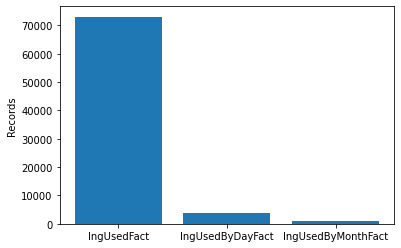

In [45]:
import matplotlib.pyplot as plt
import numpy as np
tables = ('IngUsedFact', 'IngUsedByDayFact', 'IngUsedByMonthFact')
y_pos = np.arange(len(tables))
records = [py_var_IngUsedFact_num[0][0], py_var_IngUsedByDayFact_num[0][0], py_var_IngUsedByMonthFact_num[0][0]]
plt.bar(tables, records)
plt.ylabel('Records')

plt.show()

3. (1 point) Describe the shape of the plot as it relates to the number of records. Why does the data look this way?

The ingUsedFact has the details for all ingredients for each poduct for each day, while, The IngUsedByDatFact and IngUsedByMonthFact tables store the aggregated data, and hence, have lesser number of records.

4. (4 points) Compute the minimum, maximum, and average price per product per ticket for events that started on or after 6 PM. Round each value to 2 decimal places.

Return `minPrice`, `maxPrice`, `avgPrice`

In [48]:
%%sql py_var_productPrice <<
SELECT productcode, ticket, round(min(price), 2) as minPrice, round(max(price), 2) as maxPrice, round(avg(price), 2) as avgPrice 
FROM IngUsedFact iuf 
  JOIN EventDim ed 
    ON  ed.id = iuf.event
  JOIN ProductSoldDim psd 
    ON psd.id = iuf.productsold 
WHERE EXTRACT (HOUR FROM ed.eventstart) >= 6 
GROUP BY psd.productcode, iuf.ticket;

 * postgresql+psycopg2://@/postgres
11188 rows affected.
Returning data to local variable py_var_productPrice


In [49]:
# do not modify or delete this cell
df_q04 = py_var_productPrice.DataFrame() # Save the result of this task for grading purposes
df_q04

,productcode,ticket,minprice,maxprice,avgprice
0,b,195,8.00,8.00,8.00
1,b,483,8.00,8.00,8.00
2,b,1101,8.00,8.00,8.00
3,b,1195,8.00,8.00,8.00
4,b,1243,8.00,8.00,8.00
...,...,...,...,...,...
95,bf,352,6.00,6.00,6.00
96,bf,355,6.00,6.00,6.00
97,bf,364,6.00,6.00,6.00
98,bf,368,6.00,6.00,6.00


5. (4 points)  When measured by ounces, did the truck sell more vanilla ice cream in July 2017 or August  2017? Write a **single query** that gives you the answer to this question. You may use views.  Return the number of the month. Your answer should be 6 or 7. Use the `IngUsedByMonthFact` table and time your answer. 

Name the attribute `monthSold`.

You can get the time by using ```EXPLAIN ANALYZE``` in the query cell

Report the run time. Provide your query and results. You may run the query twice, once to get the timing and once to get the results.


In [57]:
%%sql 
-- py_var_moreSalesMonthFact <<
 
SELECT month 
FROM ingusedbymonthfact 
WHERE detail='vanilla' and ingname='ice cream' and month in (7, 8) and year = 2017 
ORDER BY qty desc 
LIMIT 1;

 * postgresql+psycopg2://@/postgres
1 rows affected.


month
7


In [ ]:
# do not modify or delete this cell
df_q05 = py_var_moreSalesMonthFact.DataFrame() # Save the result of this task for grading purposes
df_q05

Time your query

In [ ]:
%%sql
EXPLAIN ANALYZE
SELECT 1; -- your code here

6. (1 point) Now, write and run an analogous query on the `IngUsedByDayFact` table. Report the run time.

In [ ]:
%%sql py_var_moreSalesDayFact <<
SELECT 1; -- your code here

In [ ]:
# do not modify or delete this cell
df_q06 = py_var_moreSalesDayFact.DataFrame() # Save the result of this task for grading purposes
df_q06

Time your query

In [ ]:
%%sql
EXPLAIN ANALYZE
SELECT 1 -- your code here;

7. (1 point) Now, write and run an analogous query on the `IngUsedFact` table. Report the run time.

In [ ]:
%%sql py_var_moreSalesFact <<
SELECT 1; -- your code here

In [ ]:
# do not modify or delete this cell
df_q07 = py_var_moreSalesFact.DataFrame() # Save the result of this task for grading purposes
df_q07

Time your query

In [ ]:
%%sql
EXPLAIN ANALYZE
SELECT  1;

In [ ]:
%%sql
EXPLAIN ANALYZE

SELECT monthSold 
FROM flavorByMonth
WHERE totalqty = (
    SELECT MAX(totalqty)
    FROM flavorByMonth);

8. (1 point) Plot the times

In [ ]:
tables = ('IngUsedFact', 'IngUsedByDayFact', 'IngUsedByMonthFact')
y_pos = np.arange(len(tables))
# REPLACE 1, 2, 3 with your values. MAKE SURE THEY ARE IN THE CORRECT ORDER!
records = [1, 2, 3]
plt.bar(tables, records)
plt.ylabel('Time')

plt.show()


9. (4 points) Write and run the following query: List the detail names and total quantity of the least popular, but non-zero valued 3 toppings on cone products - these are productcodes: `c1, c2, c3,` and `wc`, by total quantity used (in this case 'ounce'). Note that ```no topping``` is considered a topping choice. Don't worry about ties, just return the least popular 3 toppings.

Return the `detail` and `qty`.


In [ ]:
%%sql py_var_toppings <<
SELECT 1; -- your code here

In [ ]:
# do not modify or delete this cell
df_q09 = py_var_toppings.DataFrame() # Save the result of this task for grading purposes
df_q09

10. (4 points) Which day of the week (a number: 0 = Sunday, 6 = Saturday) has the highest sales of floats? (product code `fl`) by number sold? Return the total and  the day of week index in your query.

Return `total` (total number sold) and `dayofweek`.

In [ ]:
%%sql py_var_mostSales <<
SELECT 1; -- your code here

In [ ]:
# do not modify or delete this cell
df_q10 = py_var_mostSales.DataFrame() # Save the result of this task for grading purposes
df_q10

## Clean up!

(5 points) Drop any TABLEs and VIEWs you created, including the fact and dimension tables. DO NOT drop the following tables:

* productSold
* ticket
* salesRecord
* truckEvent

In [ ]:
%%sql
DROP VIEW IF EXISTS maxDOW;
DROP VIEW IF EXISTS maxVariance;
DROP VIEW IF EXISTS avgQtyPerMin;
DROP VIEW IF EXISTS qtyPerMin;
DROP VIEW IF EXISTS flavorByMonth;
DROP VIEW IF EXISTS flavorByMonthUsingDay;
